In [1]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModelForCausalLM
from transformers import pipeline, AutoTokenizer, BitsAndBytesConfig
import torch
from tqdm import tqdm
import json
import numpy as np
from typing import List
import pandas as pd
import re
import random
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

e:\Anaconda\envs\mnlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
model = AutoModelForCausalLM.from_pretrained("Tachi67/mnlp_dpo_model_bloom")
model.to(device)
tokenizer = AutoTokenizer.from_pretrained("Tachi67/mnlp_dpo_model_bloom")

Loading checkpoint shards: 100%|██████████| 2/2 [00:09<00:00,  4.53s/it]


In [3]:
from datasets import load_dataset
dataset = load_dataset("Tachi67/mnlp_dpo_data_7k")

In [12]:
def prep_input(input_sample:dict):
    prompt = input_sample['prompt']
    question_body = prompt.split('Options:')[0].strip()
    options = prompt.split('Options:')[1].strip()
    instruction = f"""Answer the following question in English:
{question_body}
Choose from the following options:
Options:\n{options}
    
Please provide only one answer with the letter of the option.
The chosen option is:
    """
    return instruction, question_body, options

def generate_answer(instruction, model, tokenizer, max_new_tokens=42): # 42 because it's the mean of the lengths of the option texts (see below)
    input = tokenizer.encode(instruction, return_tensors="pt").to(device)
    output = model.generate(input, max_new_tokens=max_new_tokens)
    output_str = tokenizer.decode(output[0], skip_special_tokens=True)
    return output_str

In [9]:
def extract_parts(text):
    # Extract the letter and the text of the option
    # Attempt to match the expected pattern "Letter. Text"
    match = re.match(r"([A-Z])\. (.*)", text)
    if match:
        return match.group(1), match.group(2).strip()
    else:
        # If no text follows the letter and period, handle gracefully
        if re.match(r"([A-Z])\.$", text.strip()):
            return text.strip()[0], ""
        else:
            print(f"Error while extracting part: {text}")
            raise ValueError("Error with extract parts")

def split_text_into_list(text):
    # Parse the options list from the options text
    items = re.split(r'(?m)^\s*([A-Z]\.)', text.strip())
    cleaned_items = []
    for i in range(1, len(items), 2):
        if i + 1 < len(items):
            cleaned_items.append(items[i] + items[i + 1])
    return cleaned_items


def parse_options(options:str):
    # Split the options into a list of tuples
    # Each tuple contains the letter and the text of the option
    options_list = split_text_into_list(options)
    res = []
    for option in options_list:
        if option:
            try:
                res.append(extract_parts(option.strip()))
            except:
                print("========")
                print("Error!!! Original text:\n",options)
                print("========")
    return res

# Example use
instruction, question_body, options = prep_input(dataset['train'][2323])
print(options)
print(parse_options(options))

A. It supports application-specific markup
B. It supports domain-specific schemas
C. It has a serialized representation
D. It uses HTML tags
[('A', 'It supports application-specific markup'), ('B', 'It supports domain-specific schemas'), ('C', 'It has a serialized representation'), ('D', 'It uses HTML tags')]


Min options: 2, Max options: 18
Statistics of token lengths in options:
Mean: 42.70197418375095, Median: 36.0, Max: 329, Min: 0


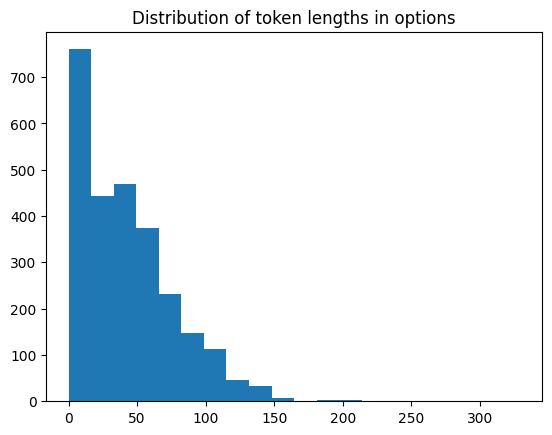

In [199]:
# min and max options
min_options = 1000
max_options = 0
for sample in zip(dataset['train'], dataset['test']):
    _, _, options = prep_input(sample[0])
    option_list = parse_options(options)
    if len(option_list) > max_options:
        max_options = len(option_list)
    if len(option_list) < min_options:
        min_options = len(option_list)

print(f"Min options: {min_options}, Max options: {max_options}")



# distributions of token length in the texts?
lengths = []
for sample in zip(dataset['train'], dataset['test']):
    _, _, options = prep_input(sample[0])
    option_list = parse_options(options)
    for option in option_list:
        lengths.append(len(option[1]))

# print some statistics
print("=======\nStatistics of token lengths in options:")
print(f"Mean: {np.mean(lengths)}, Median: {np.median(lengths)}, Max: {np.max(lengths)}, Min: {np.min(lengths)}")


# plot the distribution
import matplotlib.pyplot as plt
plt.hist(lengths, bins=20)
plt.title("Distribution of token lengths in options")
plt.show()

In [10]:
def parse_mcqa_output(whole_text:str, instruction:str, options: str):
    """
    @param whole_text (str): the output string from the model, including the input string (instructions)
    @param instruction (str): the instruction string used to generate the output (input prompts)
    @param options (str): the options given in the question, also included in the instruction
    @return (str): a single capitalized letter (A-Z), the answer to the MCQ question, as extracted from the model output.
    
    Used to parse the plain text output from the model, and extract the MCQ answer from it.
    """    
    
    def find_high_priority_answer(model_generation, len_options):
        """If the model is outputing something like:
        D
        Explanation: .....
        or:
        D.
        Explanation: .....
        or:
        (d)
        Explanation: .....
        or:
        (D)
        Explanation: ......
        
        Then we can safely assume that the answer is D and can be searched with the alphabetical search function.
        """
        best_index = len(model_generation)
        best_char = None
        characters = [chr(ord('A') + i) for i in range(len_options)]
        for char in characters:
            index = model_generation.find(char)
            if index != -1 and index < best_index:
                best_index = index
                best_char = char
        
        # match (a) or (A) patterns
        if best_char is None:
            for char in characters:
                pattern = f"({char.lower()})"
                if pattern in model_generation:
                    best_char = char
                    best_index = model_generation.find(pattern)
                    break
                
        if model_generation[best_index+1:].startswith("\n") or model_generation[best_index+1:].startswith("."):
            return best_char
        return "GG"
        
    
    def find_alphabetical_answer(model_generation, len_options):
        """Find the first capital letter in the model output, and return it as the answer.
        It's not so reliable, but it's a good fallback if the high priority search fails.
        Failure cases (example):
        "The answer is D" -> will return T
        """
        
        best_index = len(model_generation)
        best_char = None
        characters = [chr(ord('A') + i) for i in range(len_options)]
        for char in characters:
            index = model_generation.find(char)
            if index != -1 and index < best_index:
                best_index = index
                best_char = char
        # match (a) patterns
        if best_char is None:
            for char in characters:
                pattern = f"({char.lower()})"
                if pattern in model_generation:
                    best_char = char
                    break
        if best_char is None:
            return "GG"
        return best_char
    
    # Below are content matching functions, to either match model geneation again the options, or the reverse.
    
    def clean_model_generation(model_generation):
        # cleaning the model output
        model_generation = model_generation.strip()
        # remove the first - if it exists
        if model_generation.startswith("-"):
            model_generation = model_generation[1:]
        # remove the starting 'Option x:' if it exists
        model_generation = re.sub(r"Option \d+: ", "", model_generation)
        return model_generation.strip()
    
    
    def match_option_content(model_generation, options_list):
        # match the options against the model generation
        # find the option that is closest to the start of the model generation, it's the most likely answer
        model_generation = clean_model_generation(model_generation)
        best_option = None
        best_index = len(model_generation)
        for option in options_list:
            match_pos = model_generation.find(option[1])
            if match_pos != -1 and best_index > match_pos:
                best_index = match_pos
                best_option = option[0]
        if best_option is None:
            return "GG"
        return best_option
    
    
    def match_option_content_reverse(model_generation, options_list):
        # match the model generation against the options
        model_generation = clean_model_generation(model_generation)
        for option in options_list:
            option_text = option[1]
            if model_generation in option_text:
                return option[0]
        return "GG"
    
    def dangerous_match(model_generation, options_list):
        # some model generations contain latex code that is not exactly what the options are
        # e.g. model generation = \emph{some text}, while the option = some text
        # it's a bit dangerous, because there are also math expressions in the context
        # so we use the match for the least priority
        def dangerous_clean(text):
            clean_text = re.sub(r"\\[a-zA-Z]+\{([^}]+)\}", r"\1", text)
            return clean_text
        # clean the model generation
        model_generation = clean_model_generation(model_generation)
        model_generation = dangerous_clean(model_generation)
        # also clean the options
        new_options_list = options_list.copy()
        for idx, option in enumerate(new_options_list):
            # option[1] = dangerous_clean(option[1])
            new_options_list[idx] = (option[0], dangerous_clean(option[1]))
        # do the pos and reverse match for the dangerous cleaned text
        pos_match = match_option_content(model_generation, new_options_list)
        rev_match = match_option_content_reverse(model_generation, new_options_list)
        if pos_match != "GG":
            return pos_match
        elif rev_match != "GG":
            return rev_match
        else:
            return "GG"
    
    try:   
        model_generation = whole_text[len(instruction):] # remove the instruction part, only keep the answer
        options_list = parse_options(options)
        len_options = len(options_list)
        
        high_priority_search = find_high_priority_answer(model_generation, len_options)
        AB_search = find_alphabetical_answer(model_generation, len_options)
        content_search =  match_option_content(model_generation, options_list = options_list)
        reverse_content_serach =  match_option_content_reverse(model_generation, options_list = options_list)
        dangerous_search = dangerous_match(model_generation, options_list = options_list)
       
        # note the priority order
        if high_priority_search != "GG":
            return high_priority_search
        elif reverse_content_serach != "GG":
            return reverse_content_serach
        elif content_search != "GG":
            return content_search
        elif AB_search != "GG":
            return AB_search
        elif dangerous_search != "GG":
            return dangerous_search
        else:
            # all search failed, return a random guess
            return random.choice([chr(ord('A') + i) for i in range(len_options)])
    except:
        # something unexpected happened, return a random guess
        return random.choice([chr(ord('A') + i) for i in range(26)])
        

In [315]:
####################
#      TESTS
####################

instruction = """Answer the following question in English:
Question: When searching for an entity 𝑒𝑛𝑒𝑤 that has a given relationship 𝑟 with a given entity 𝑒?
Choose from the following options:
Options:
A. We search for 𝑒𝑛𝑒𝑤 that have a similar embedding vector to 𝑒
B. We search for 𝑒𝑛𝑒𝑤 that have a similar embedding vector to 𝑒𝑜𝑙𝑑 which has relationship 𝑟 with 𝑒
C. We search for pairs (𝑒𝑛𝑒𝑤, 𝑒) that have similar embedding to (𝑒𝑜𝑙𝑑, 𝑒)
D. We search for pairs (𝑒𝑛𝑒𝑤, 𝑒) that have similar embedding to (𝑒𝑜𝑙𝑑, 𝑒) for 𝑒𝑜𝑙𝑑 which has relationship 𝑟 with 𝑒
    
Please provide only one answer with the letter of the option.
The chosen option is:"""


answer = """
     D

Explanation:
1. We search for pairs (𝑒𝑛𝑒𝑤, 𝑒) that have similar embedding to (𝑒𝑜𝑙𝑑, 𝑒) for 𝑒𝑜𝑙𝑑 which has relationship �"""
    


# options = """A. (a) True\nB. (b) False"""
# options = """A. The math is adasd\nB. The math is sisisi\n C. The math is iiiii\n D. The math is X.T.Y."""
# options = """A. $2 xv^	op A$
# B. $2Axv$
# C. $A^	op xv + Axv$
# D. $2A^	op xv$"""
options = """A. We search for 𝑒𝑛𝑒𝑤 that have a similar embedding vector to 𝑒
B. We search for 𝑒𝑛𝑒𝑤 that have a similar embedding vector to 𝑒𝑜𝑙𝑑 which has relationship 𝑟 with 𝑒
C. We search for pairs (𝑒𝑛𝑒𝑤, 𝑒) that have similar embedding to (𝑒𝑜𝑙𝑑, 𝑒)
D. We search for pairs (𝑒𝑛𝑒𝑤, 𝑒) that have similar embedding to (𝑒𝑜𝑙𝑑, 𝑒) for 𝑒𝑜𝑙𝑑 which has relationship 𝑟 with 𝑒"""

whole_text = instruction + answer


# parse_mcqa_output(whole_text, instruction, options)
options_list = parse_options(options)

parse_mcqa_output(whole_text, instruction, options)

'D'

In [13]:
index = random.randint(0, len(dataset['test']))
instruction, question_body, options = prep_input(dataset['test'][index])
print("Instruction:\n===================\n")
print(instruction)
print("===================")

output_str_new_model = generate_answer(instruction, model, tokenizer, max_new_tokens=42)
print("Model generation (with input)\n")
print(output_str_new_model)
print("MCQA ANSWER ----------------->", parse_mcqa_output(output_str_new_model, instruction, options))

Instruction:

Answer the following question in English:
Question: Consider a binary classification problem with classifier $f(\mathbf{x})$ given by $$ f(\mathbf{x})= \begin{cases}1, & g(\mathbf{x}) \geq 0 \\ -1, & g(\mathbf{x})<0\end{cases} $$ and $\mathbf{x} \in \mathbb{R}^{6}$. Consider a specific pair $(\mathbf{x}, y=1)$ and assume that $g(\mathbf{x})=8$. In particular this means that this point is classified correctly by $f$. Assume further that we have computed the gradient of $g$ at $\mathbf{x}$ to be $\nabla_{\mathbf{x}} g(\mathbf{x})=(+1,-2,+3,-4,+5,-6)$. You are allowed to make one step in order to (hopefully) find an adversarial example. In the following four questions, assume $\epsilon=1$. Which offset $\delta$ with $\|\delta\|_{1} \leq 1$ yields the smallest value for $g(\mathbf{x}+\delta)$, assuming that $g$ is (locally) linear?
Choose from the following options:
Options:
A. $(0,0,0,0,0,1)$
B. $(+1,-1,+1,-1,+1,-1)$
C. $(+1,-2,+3,-4,+5,-6)$
D. $(+1,+1,+1,+1,+1,+1)$
E. $(-1,